In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'AKE.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,1478,-1214,264,25,360,910,975,2402,0,...,648,0,212,1187,1202,3309,171,-119,67.0,2014-11-09
1,2014-12-31,1431,-1213,218,25,1149,839,977,3131,747,...,704,0,107,1131,1194,3285,162,-112,67.0,2015-02-24
2,2015-03-31,1871,-1531,340,40,238,1319,1243,3034,0,...,883,0,228,1593,1898,4723,34,-96,74.0,2015-05-05
3,2015-06-30,2106,-1678,428,134,350,1356,1193,3121,1396,...,858,0,234,1577,1887,4891,220,-131,74.0,2015-07-28
4,2015-09-30,1946,-1553,393,59,476,1221,1194,3116,0,...,832,0,217,1534,1891,4829,224,-85,74.0,2015-11-09


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-06-30,2023-07-28,75.0,2442,-1900,542,152,1666,1460,1379,...,2109,13516,998,412,248,2222,2809,6384,274,-152
36,2023-09-30,2023-11-09,75.0,2326,-1835,491,117,1900,1396,1347,...,2099,13667,946,0,664,2204,2955,6317,393,-149
37,2023-12-31,2024-02-29,75.0,2222,-1797,425,23,2045,1261,1208,...,2416,14517,1036,389,152,2079,3578,7314,462,-181
38,2024-03-31,2024-05-06,75.0,2341,-2022,319,80,2316,1465,1326,...,2423,15117,1068,0,1247,2855,3032,7131,85,-170
39,2024-06-30,2024-07-29,75.0,2536,-1965,571,149,2094,1539,1361,...,2400,15091,1114,0,1226,2871,3038,7187,295,-149


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-07-28,75.0,2442,-1900,542,152,1666,1460,1379,...,13516,998,412,248,2222,2809,6384,274,-152,0.918362
36,2023-09-30,2023-11-09,75.0,2326,-1835,491,117,1900,1396,1347,...,13667,946,0,664,2204,2955,6317,393,-149,0.918837
37,2023-12-31,2024-02-29,75.0,2222,-1797,425,23,2045,1261,1208,...,14517,1036,389,152,2079,3578,7314,462,-181,0.929674
38,2024-03-31,2024-05-06,75.0,2341,-2022,319,80,2316,1465,1326,...,15117,1068,0,1247,2855,3032,7131,85,-170,0.920544
39,2024-06-30,2024-07-29,75.0,2536,-1965,571,149,2094,1539,1361,...,15091,1114,0,1226,2871,3038,7187,295,-149,0.928647


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-07-28,75.0,2442,-1900,542,152,1666,1460,1379,...,13516,998,412,248,2222,2809,6384,274,-152,0.918362
36,2023-09-30,2023-11-09,75.0,2326,-1835,491,117,1900,1396,1347,...,13667,946,0,664,2204,2955,6317,393,-149,0.918837
37,2023-12-31,2024-02-29,75.0,2222,-1797,425,23,2045,1261,1208,...,14517,1036,389,152,2079,3578,7314,462,-181,0.929674
38,2024-03-31,2024-05-06,75.0,2341,-2022,319,80,2316,1465,1326,...,15117,1068,0,1247,2855,3032,7131,85,-170,0.920544
39,2024-06-30,2024-07-29,75.0,2536,-1965,571,149,2094,1539,1361,...,15091,1114,0,1226,2871,3038,7187,295,-149,0.928647


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,39.689354,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.429679,0.570321,0.0,0.0,0.0,0.0,0.17862,0.016915,0.0,0.0
1,2014-11-17,38.993637,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.429679,0.570321,0.0,0.0,0.0,0.0,0.17862,0.016915,0.0,0.0
2,2014-11-24,41.088615,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.429679,0.570321,0.0,0.0,0.0,0.0,0.17862,0.016915,0.0,0.0
3,2014-12-01,43.048435,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.429679,0.570321,0.0,0.0,0.0,0.0,0.17862,0.016915,0.0,0.0
4,2014-12-08,39.429142,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.429679,0.570321,0.0,0.0,0.0,0.0,0.17862,0.016915,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,39.689354,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.0,0.17862,0.016915,0.0,0.0,inf,1.066661,inf,inf,inf
1,2014-11-17,38.993637,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.0,0.17862,0.016915,0.0,0.0,inf,1.047964,inf,inf,inf
2,2014-11-24,41.088615,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.0,0.17862,0.016915,0.0,0.0,inf,1.104267,inf,inf,inf
3,2014-12-01,43.048435,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.0,0.17862,0.016915,0.0,0.0,inf,1.156937,inf,inf,inf
4,2014-12-08,39.429142,2014-09-30,1478.0,0.0,37.208955,67.0,0.0,0.0,360.0,...,0.0,0.17862,0.016915,0.0,0.0,inf,1.059668,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

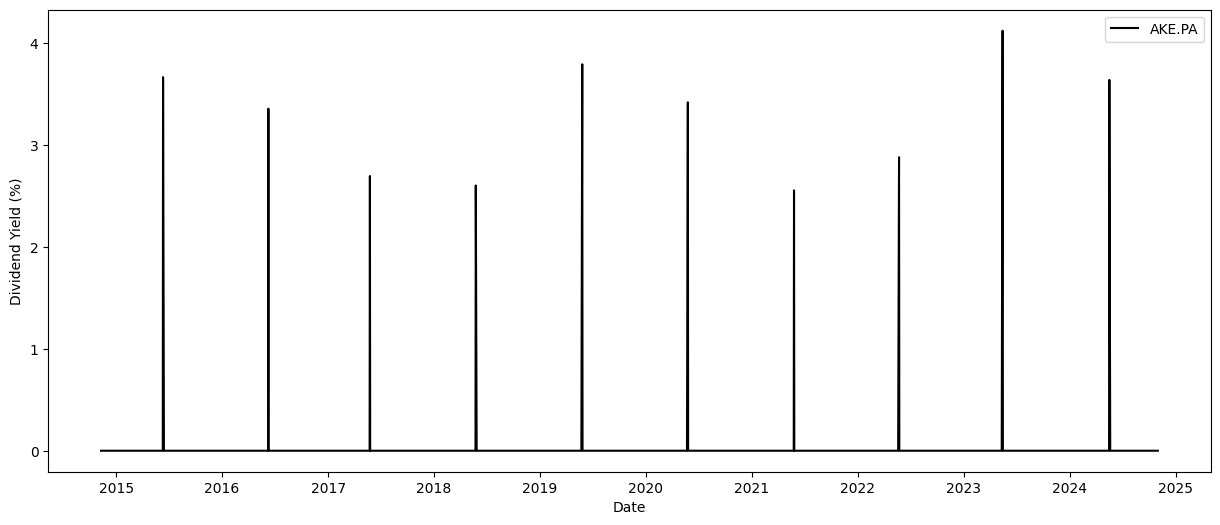

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.068117
share_price      1.000000
Name: share_price, dtype: float64


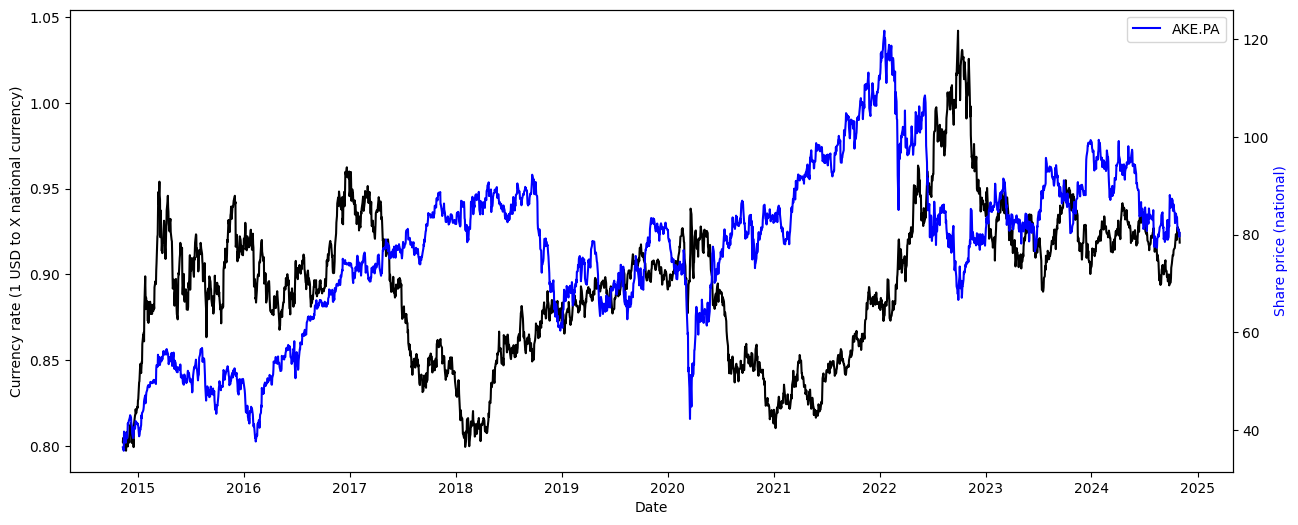

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

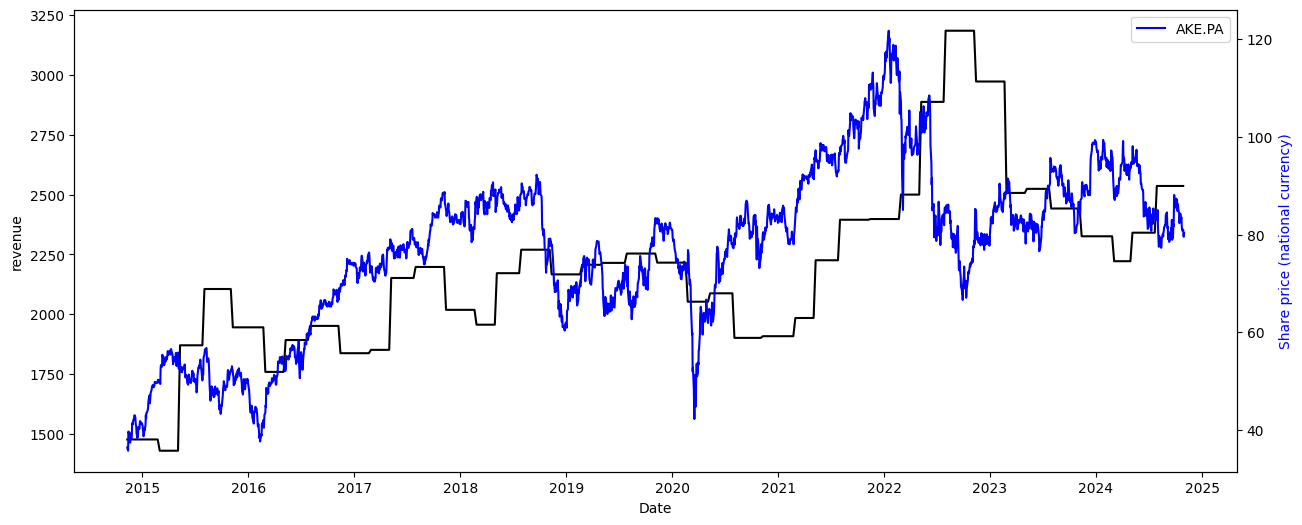

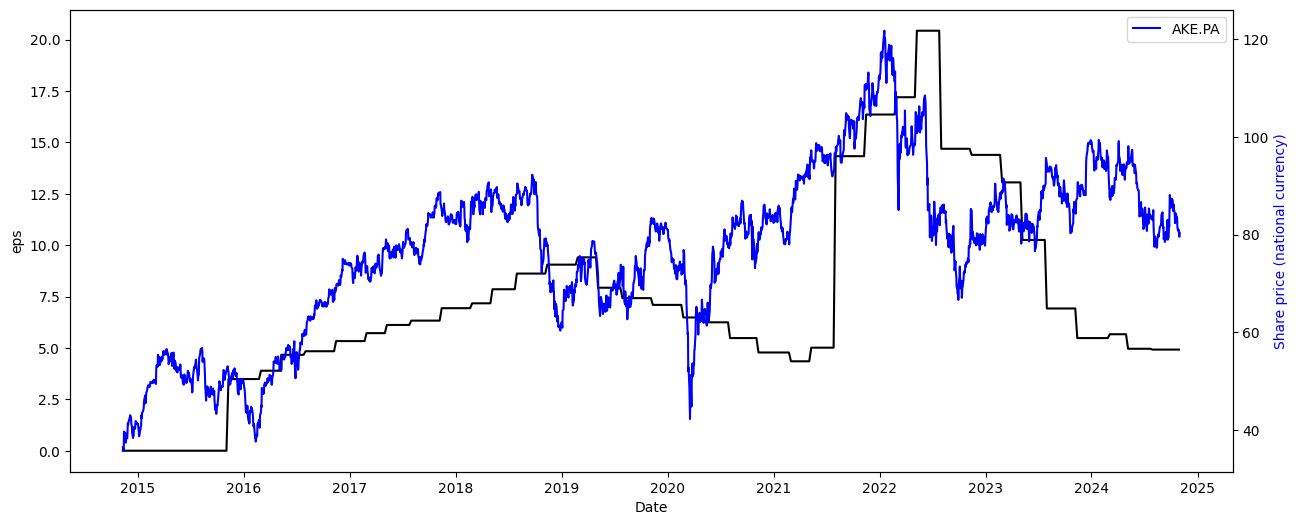

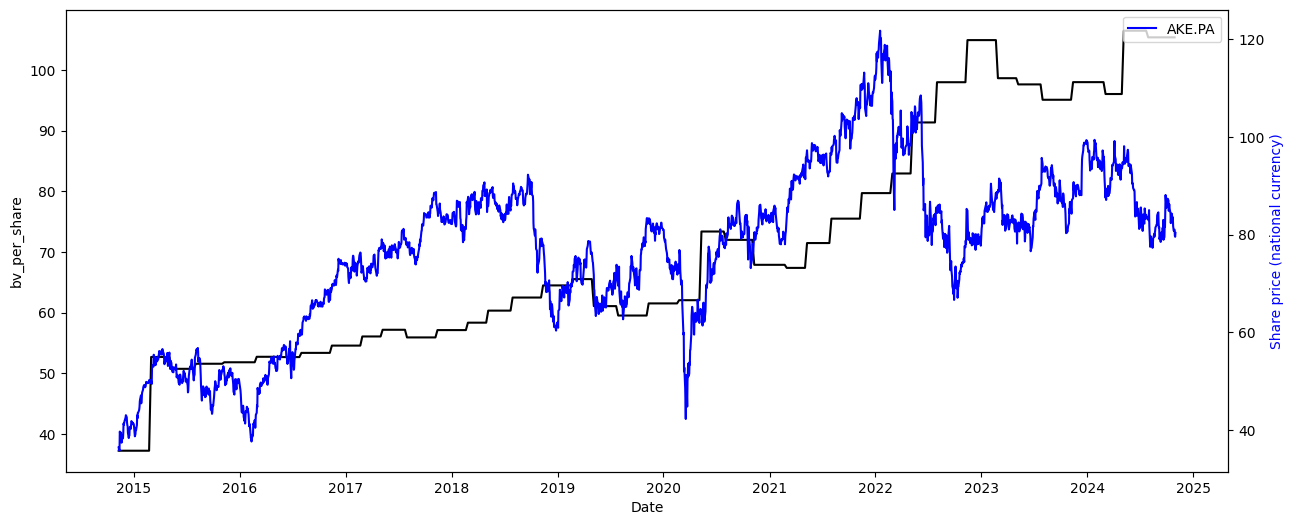

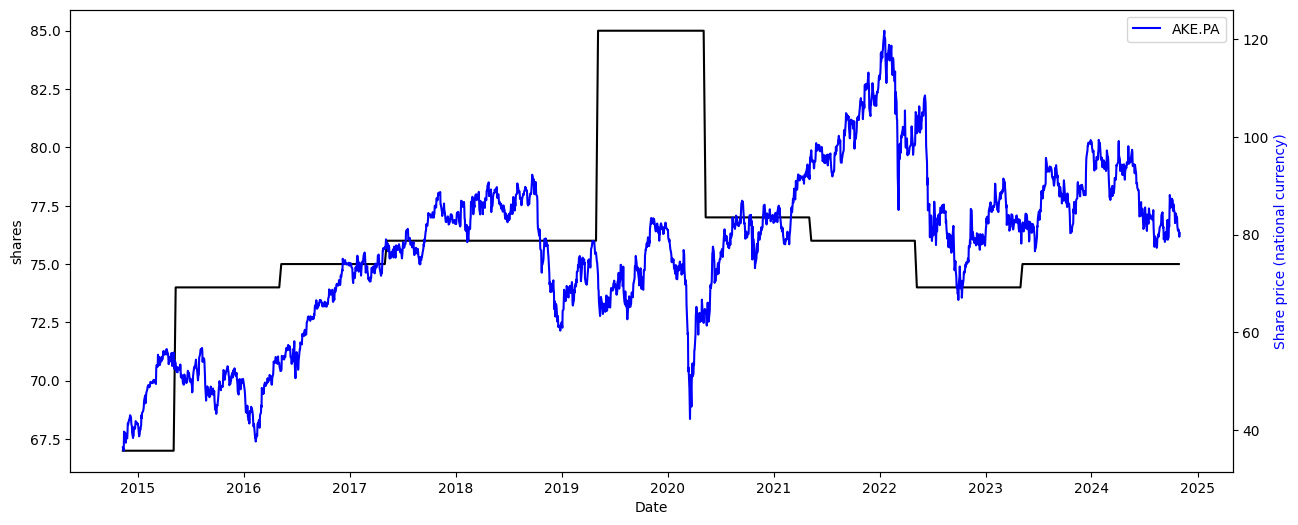

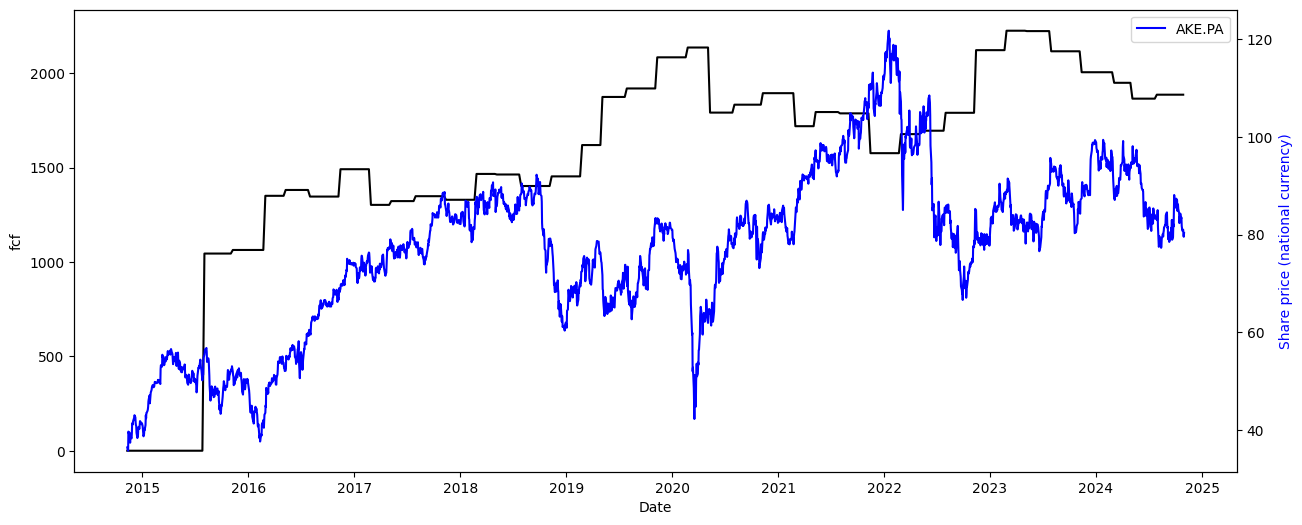

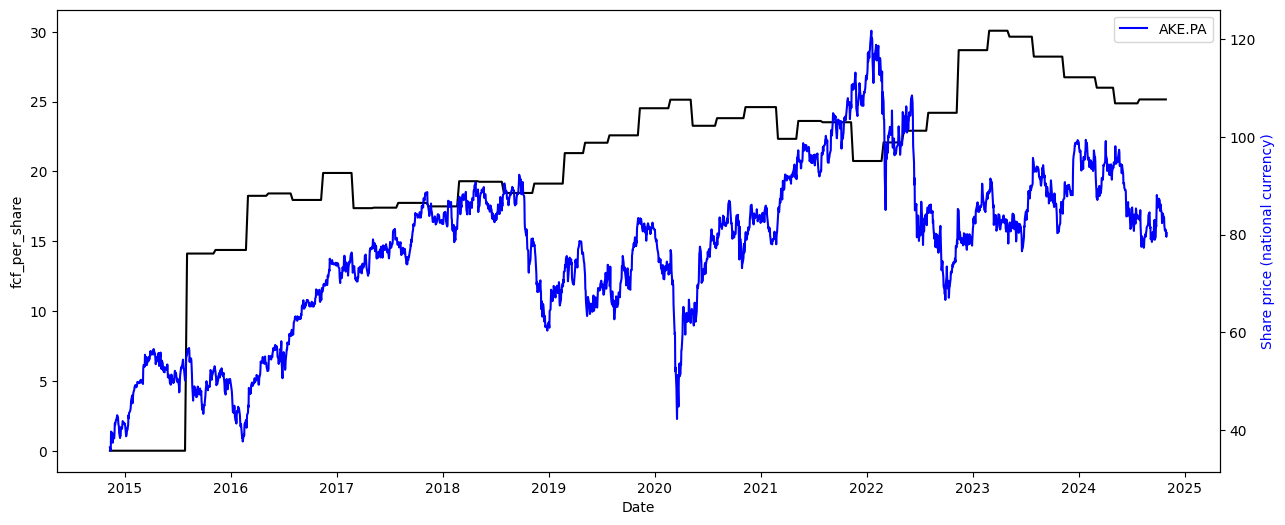

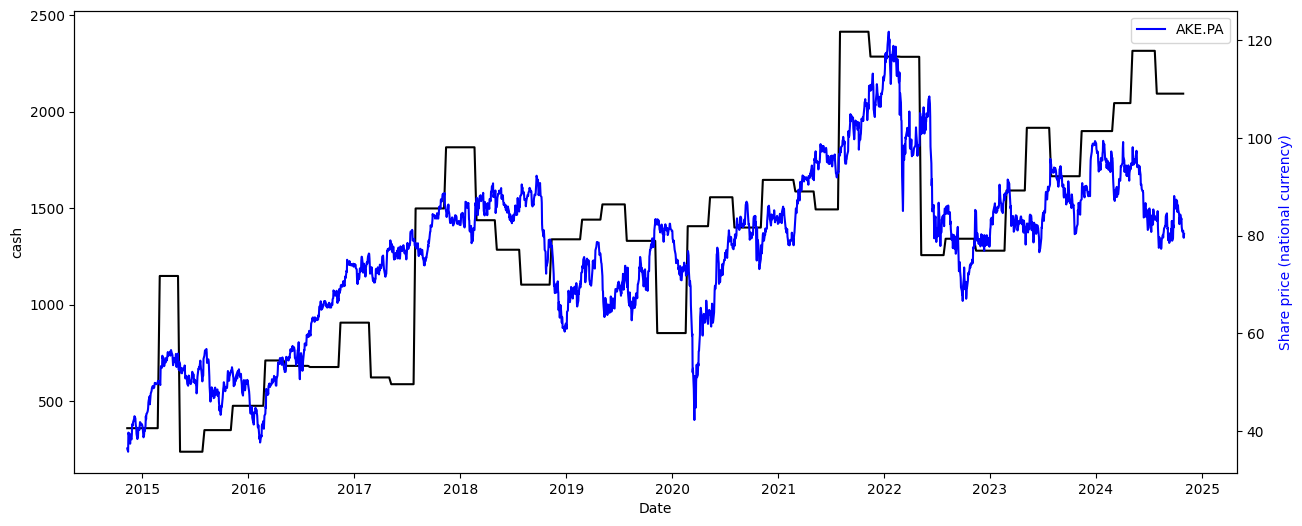

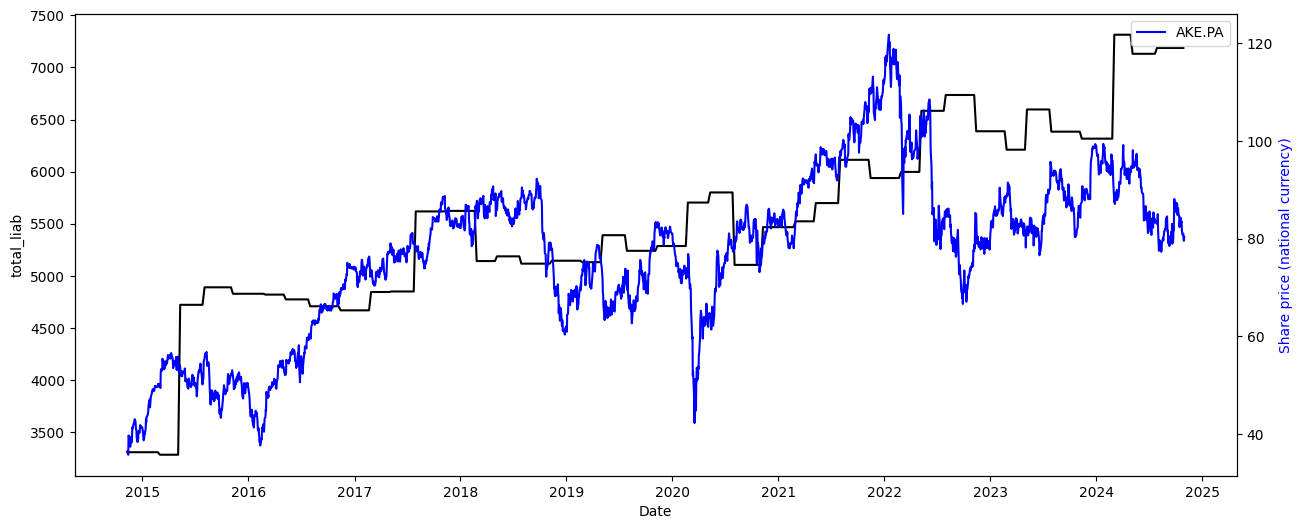

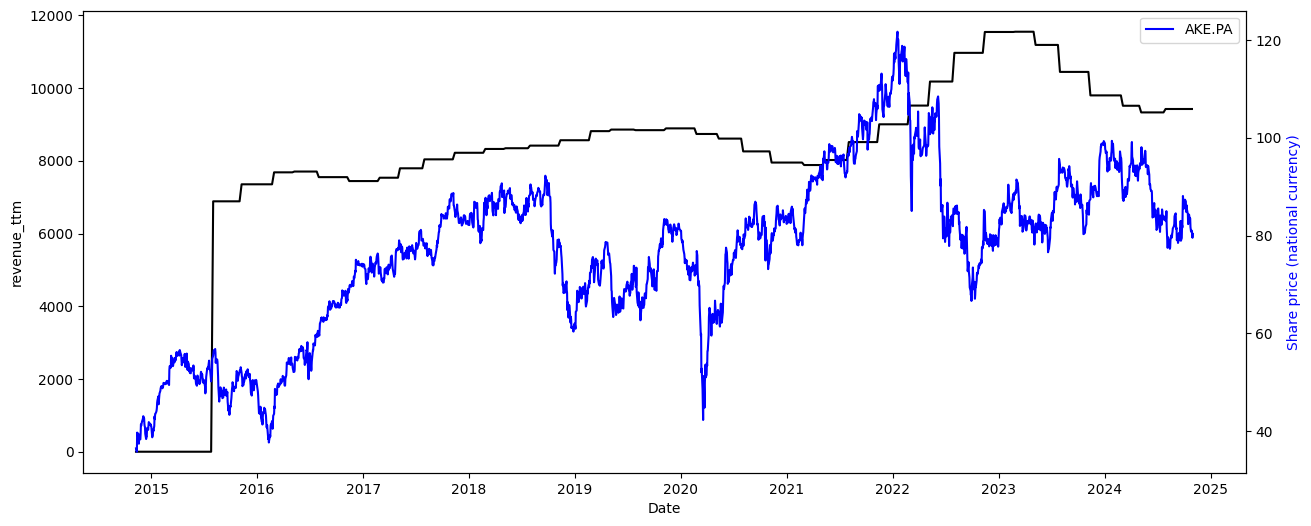

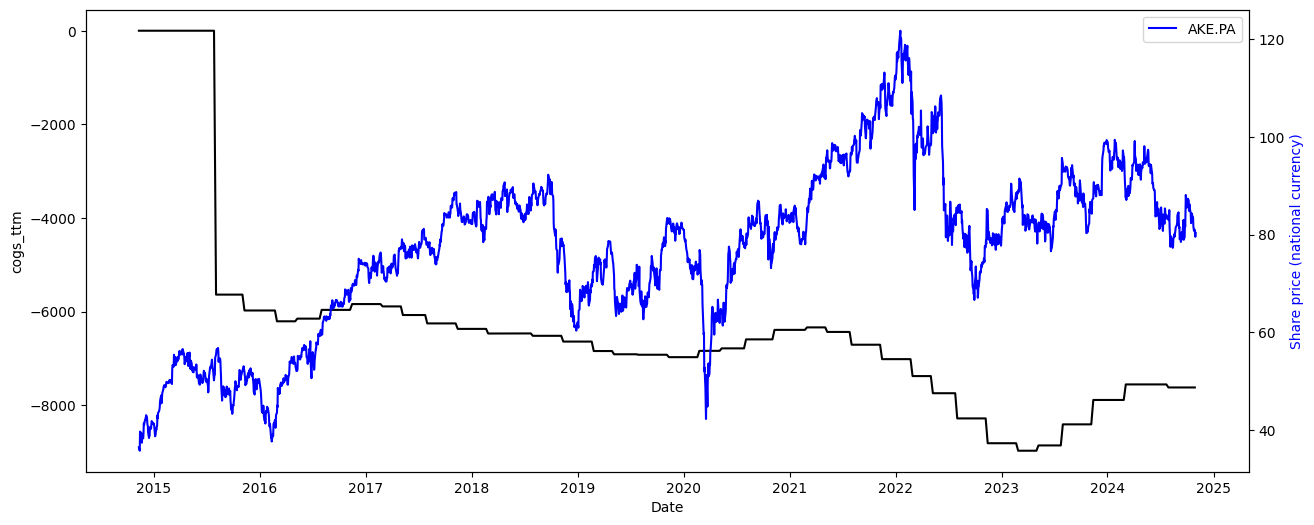

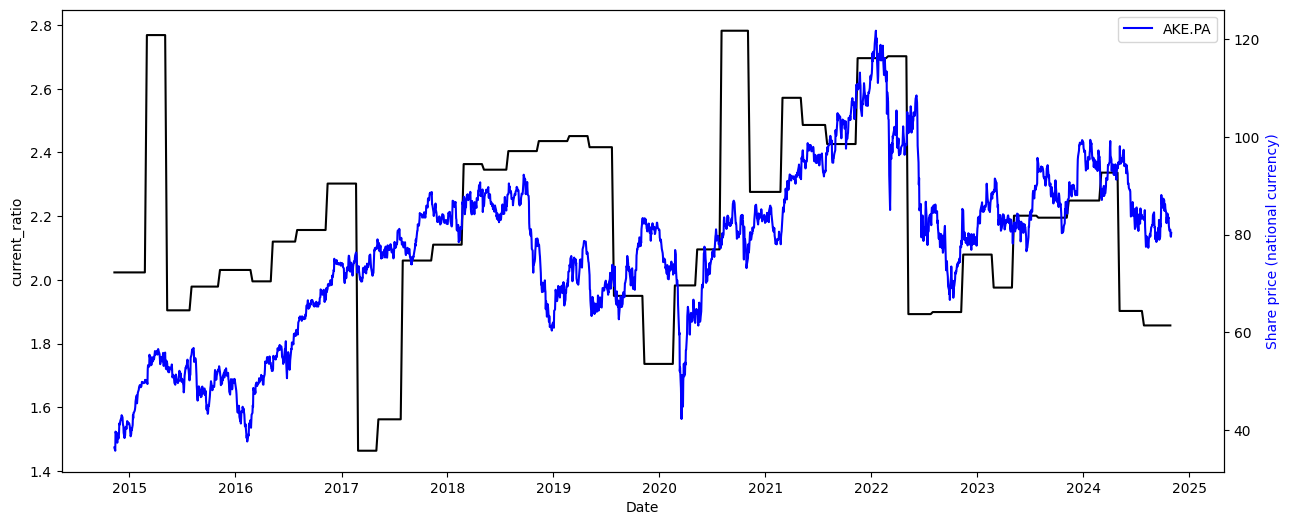

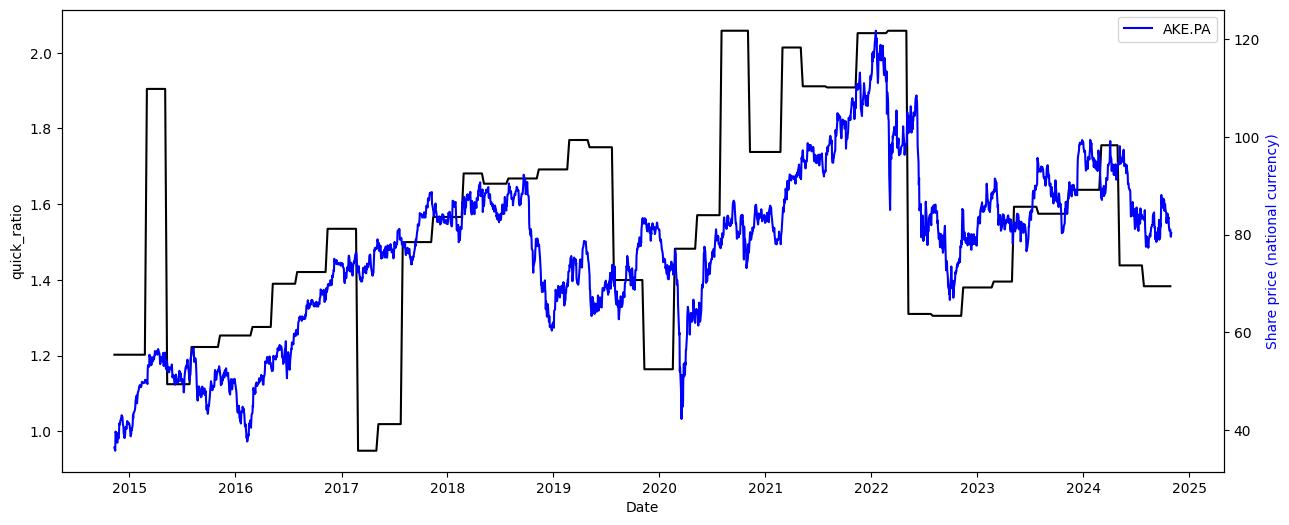

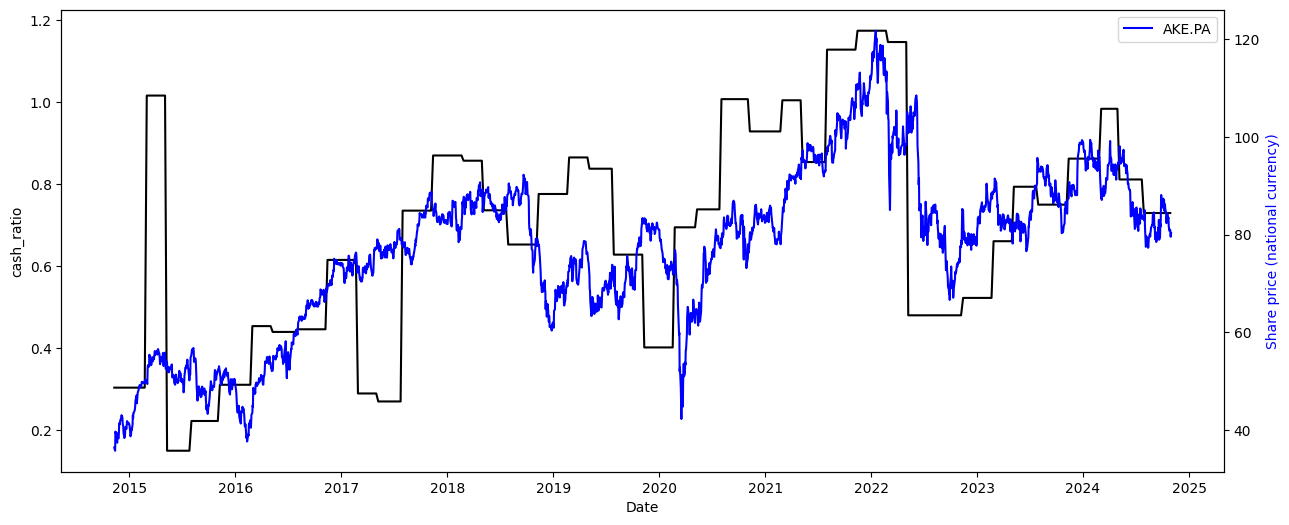

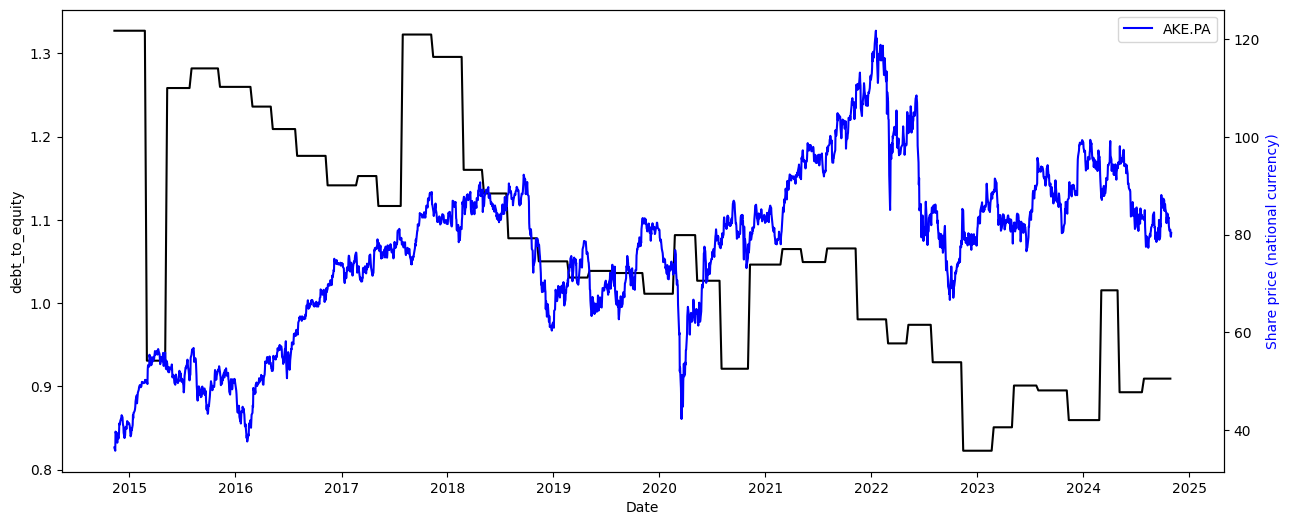

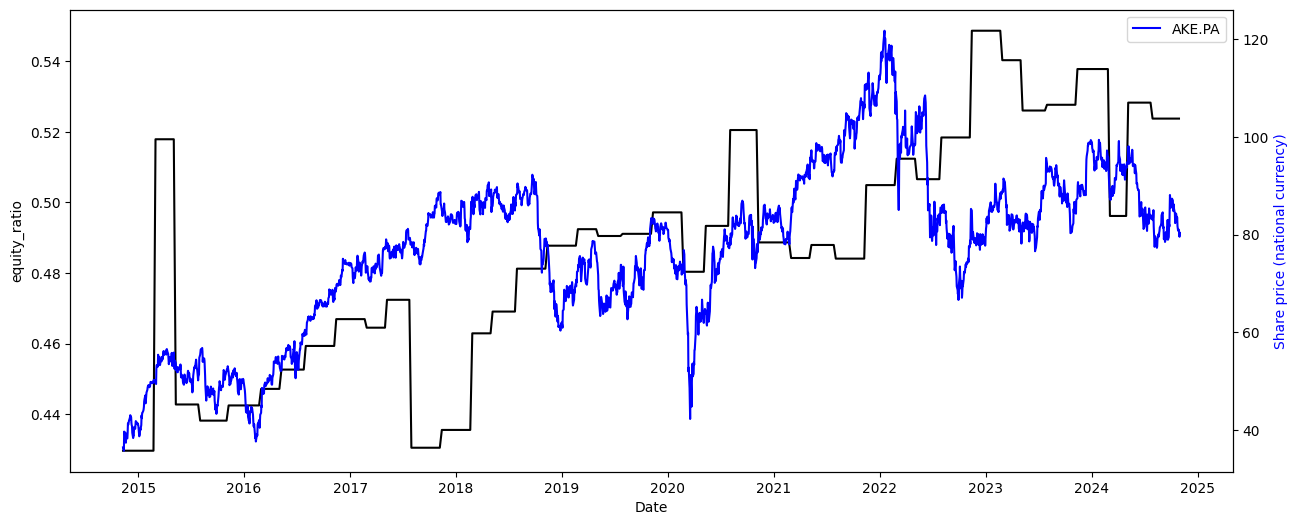

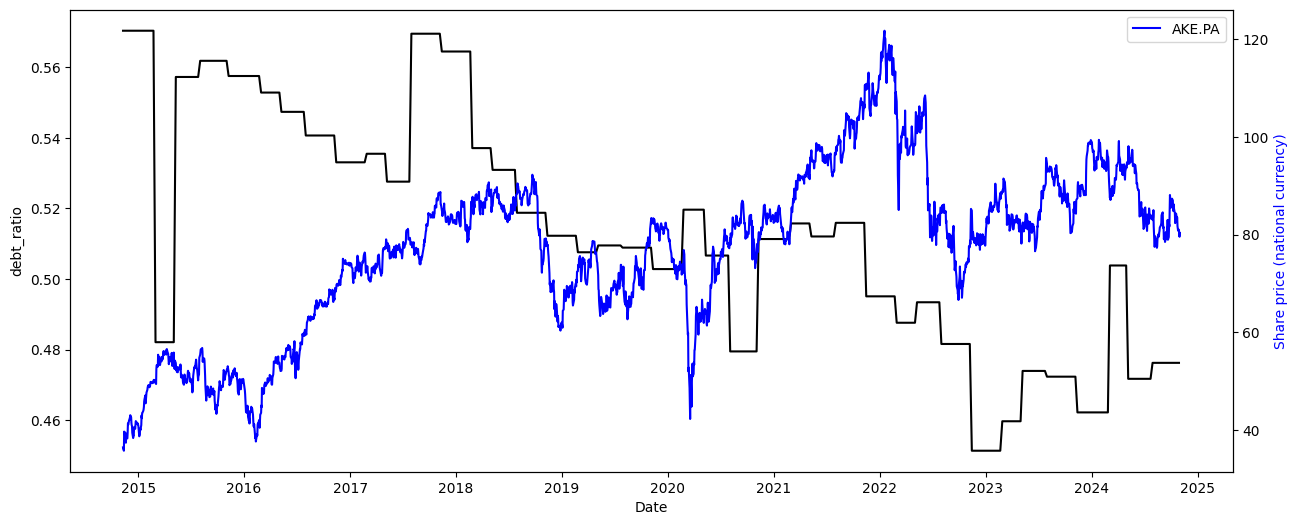

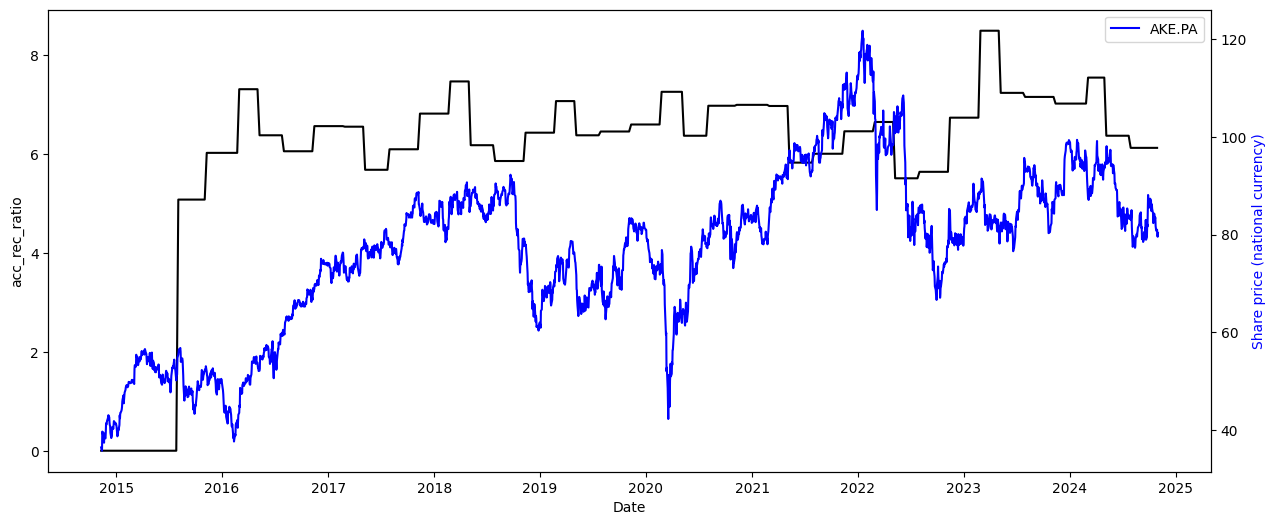

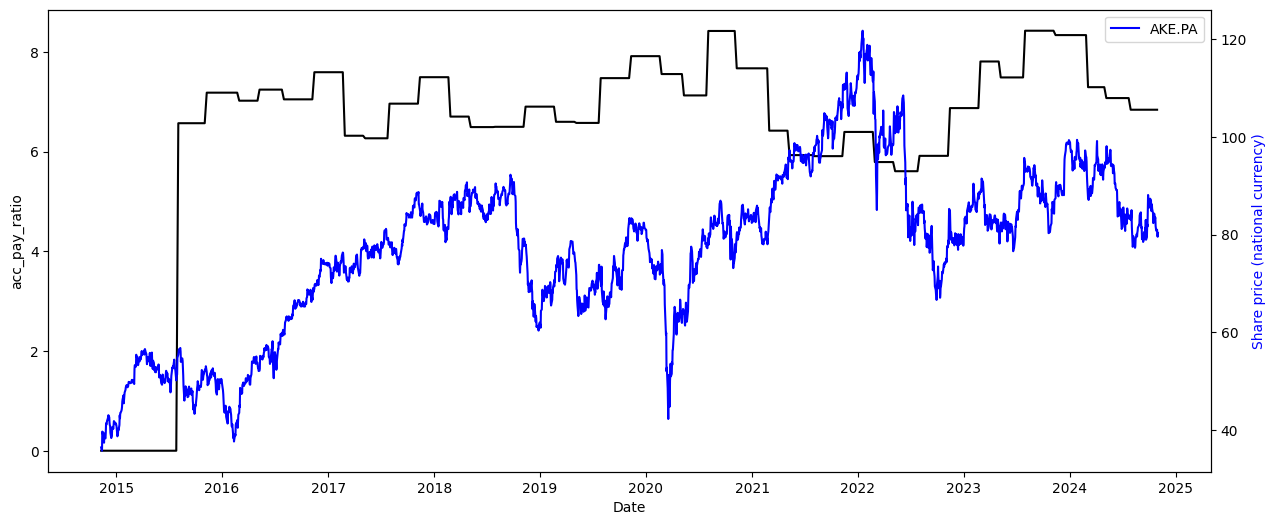

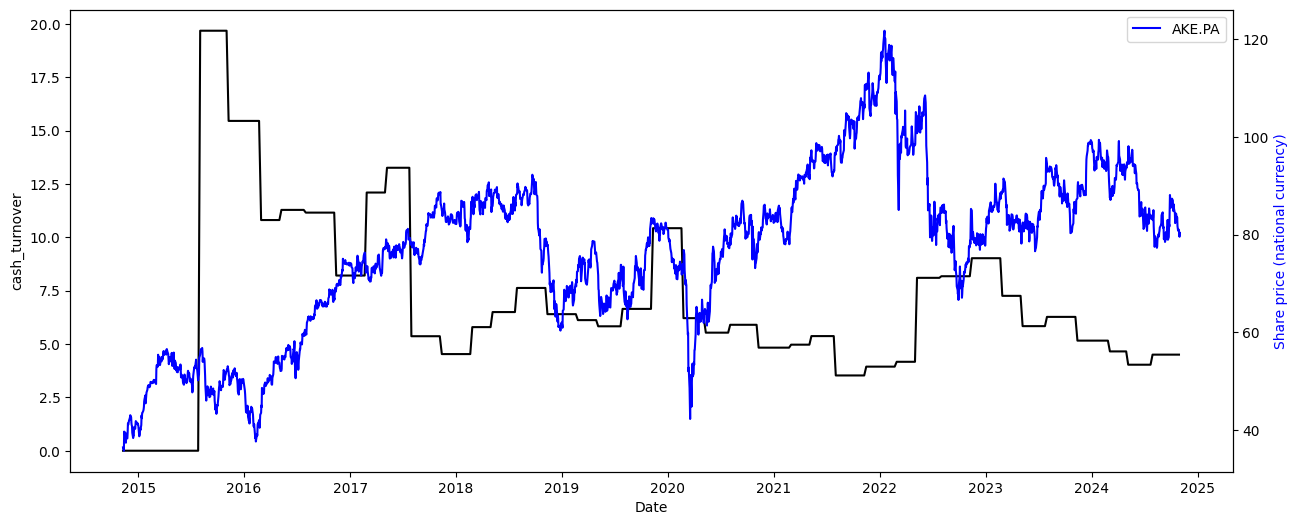

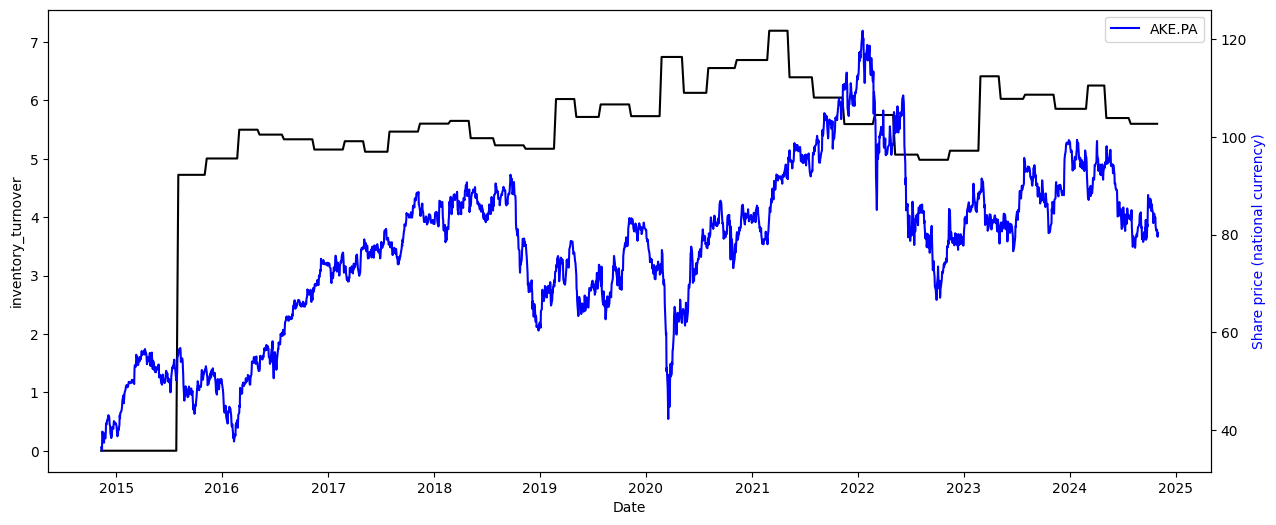

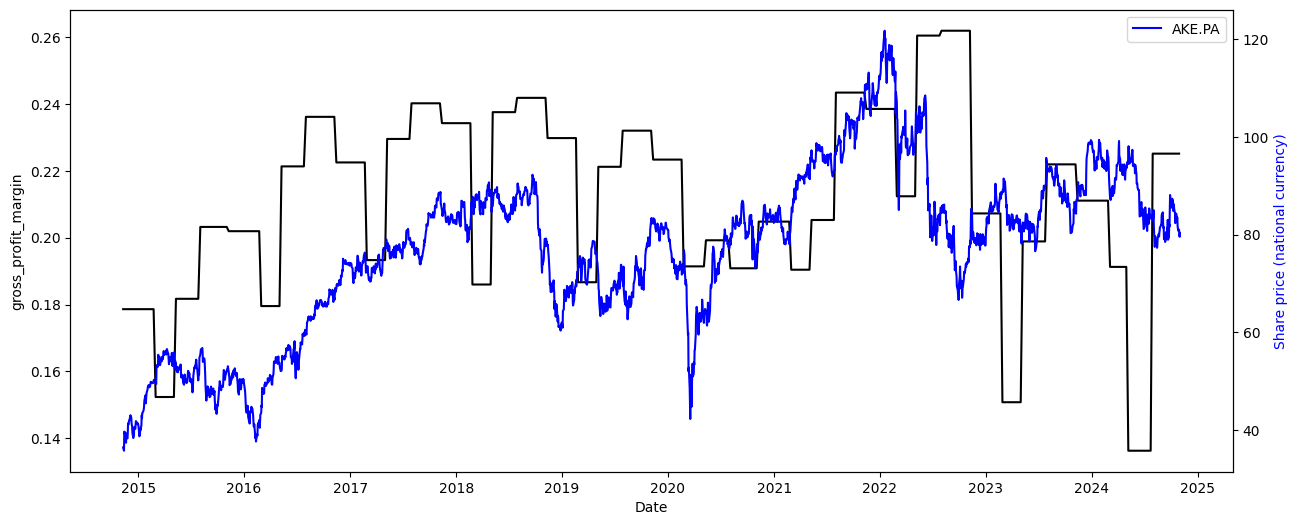

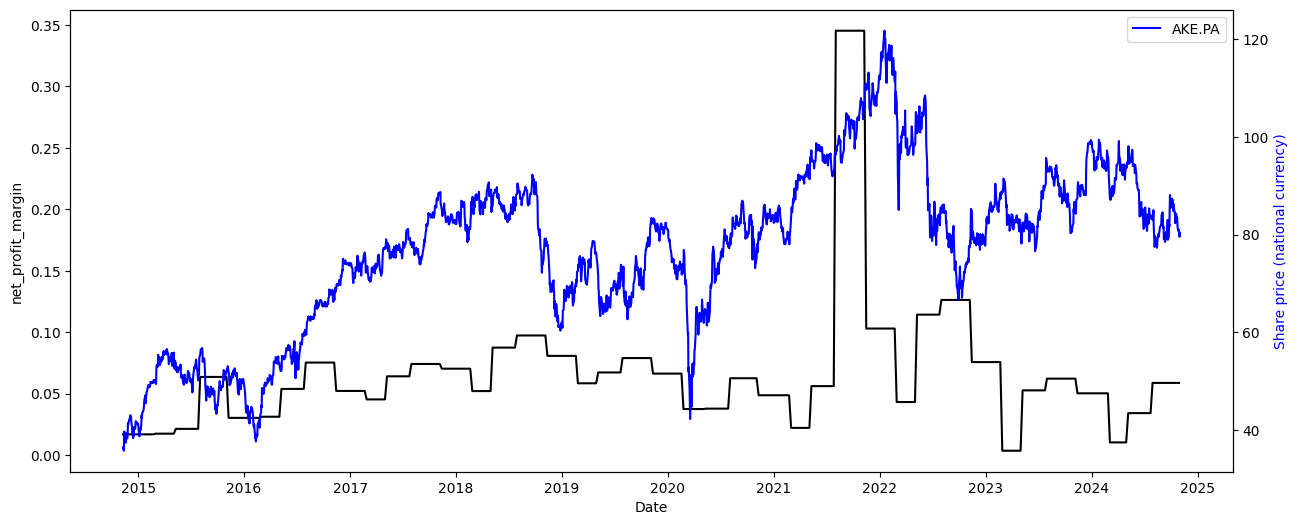

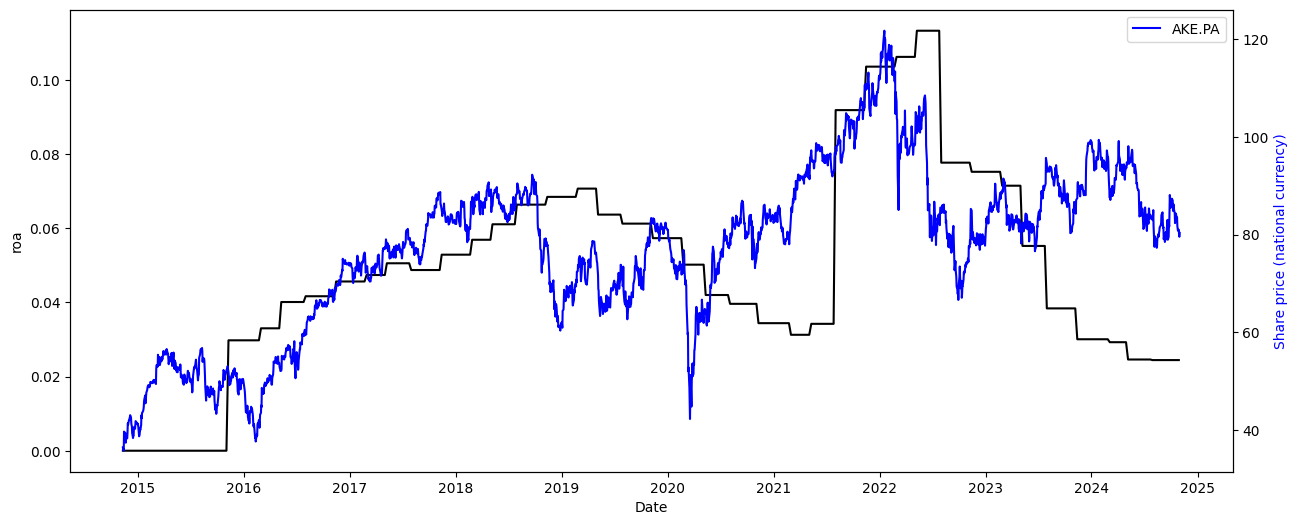

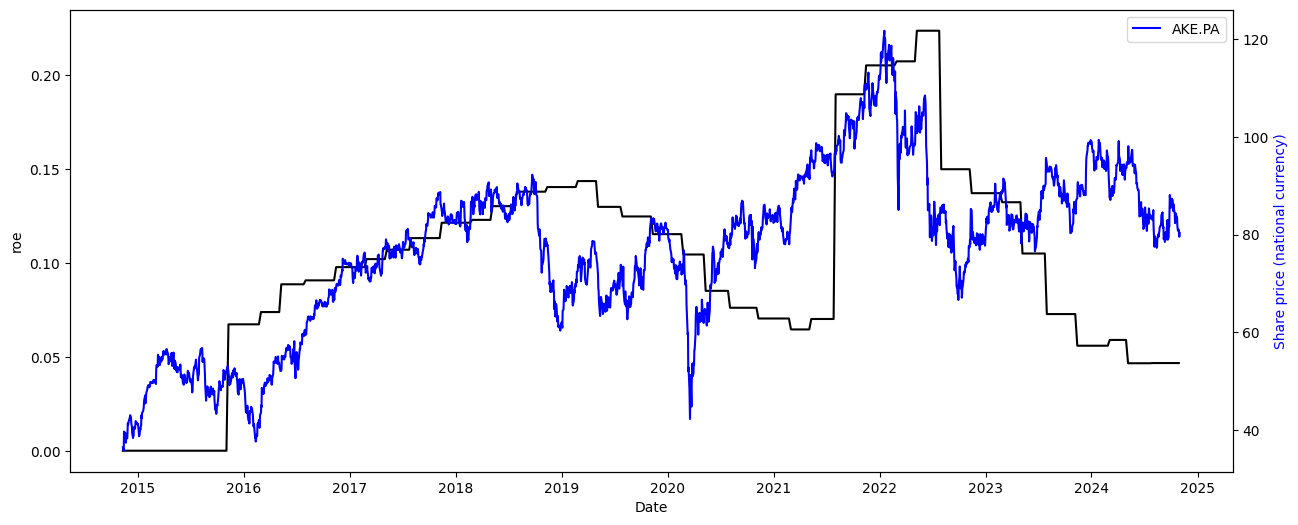

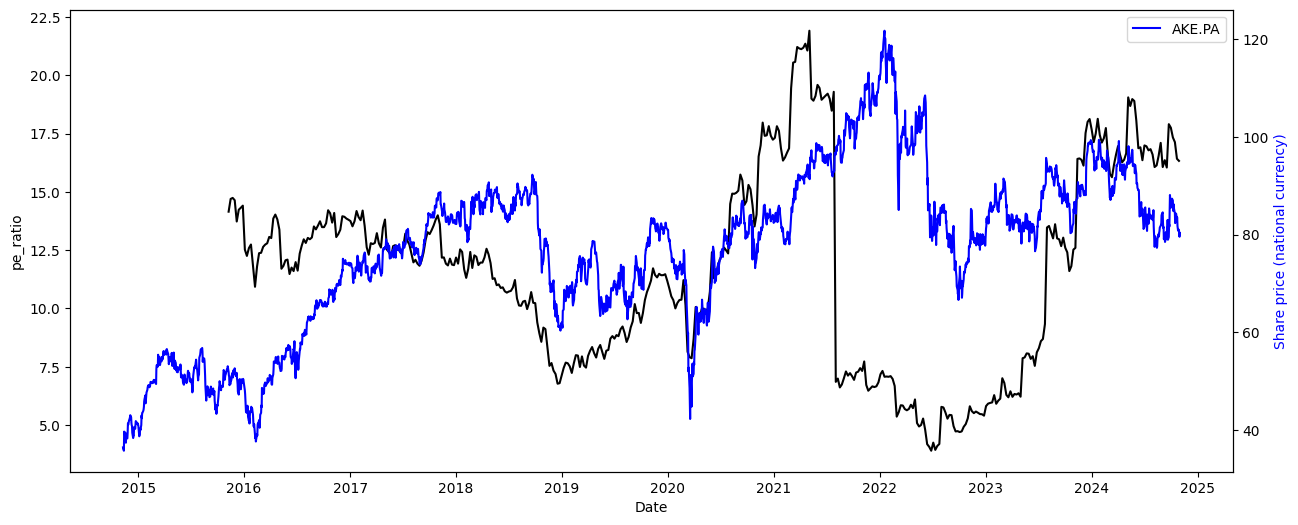

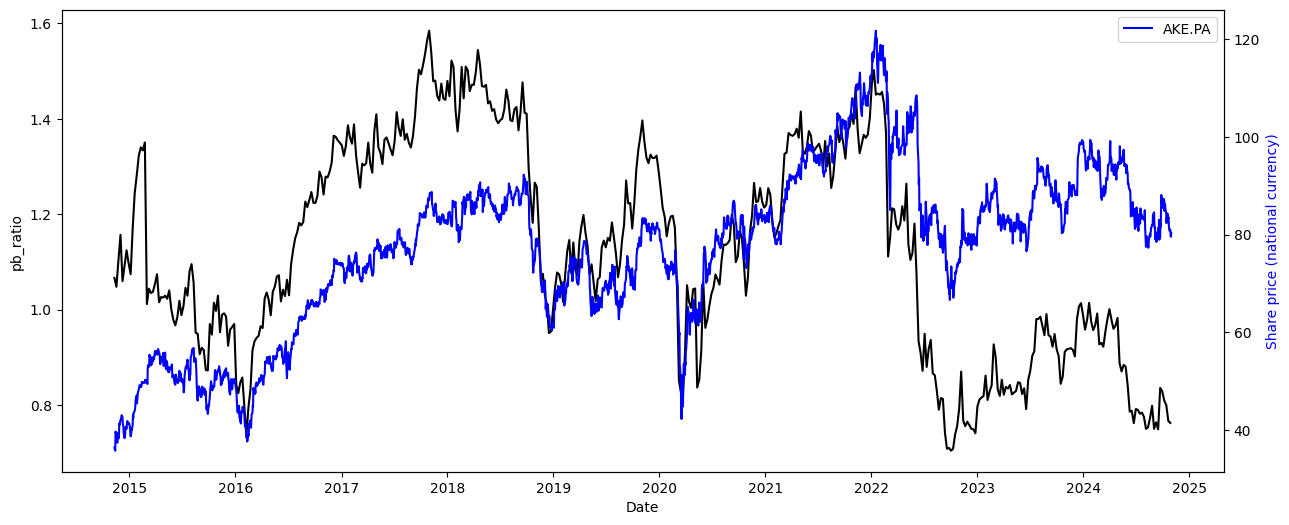

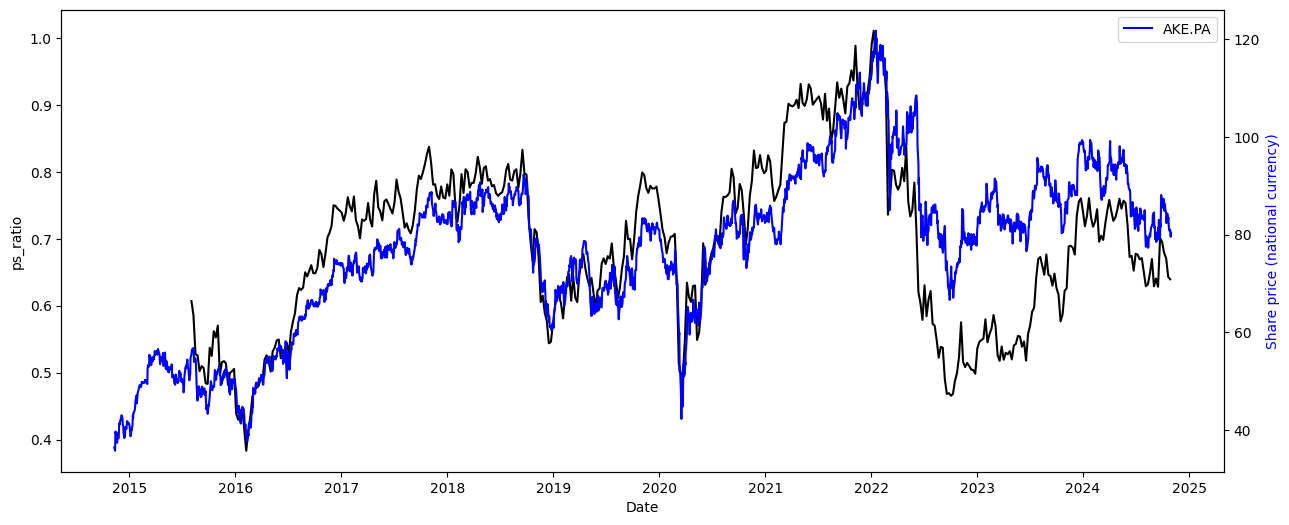

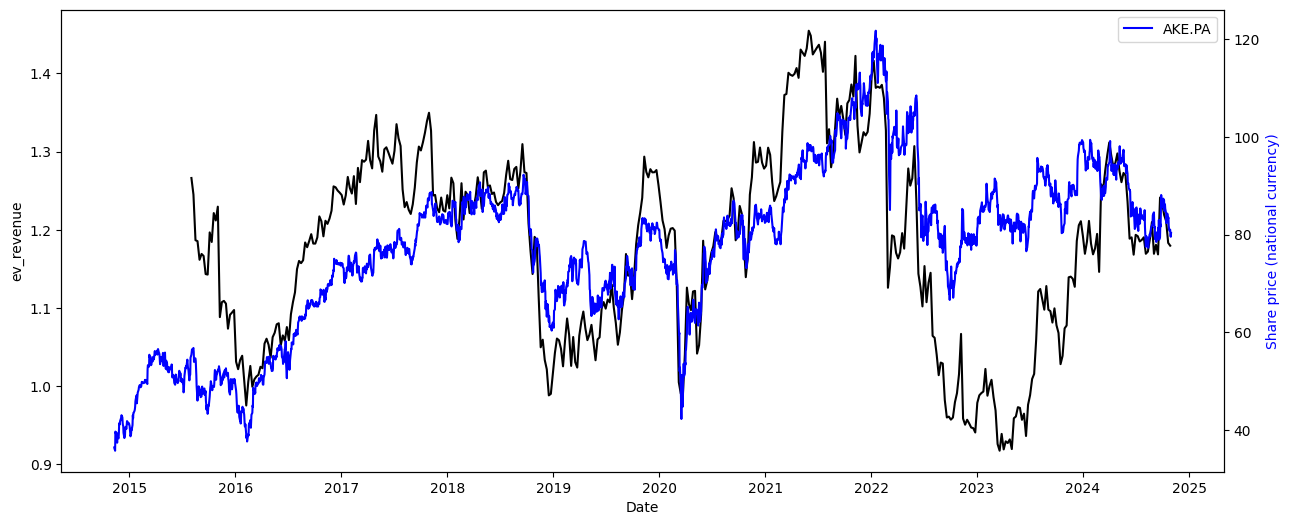

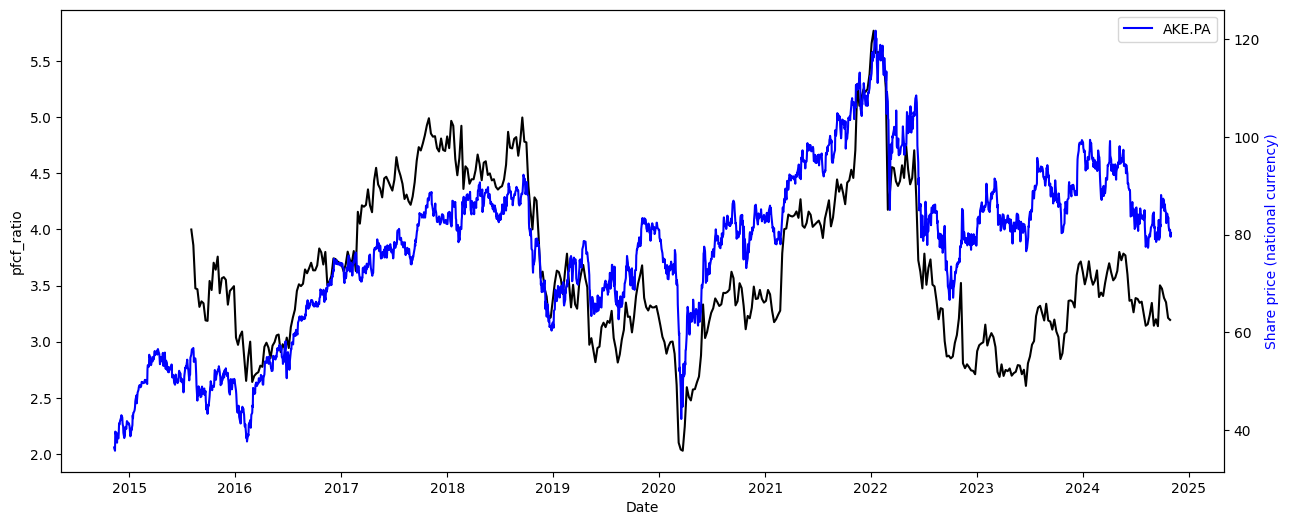

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

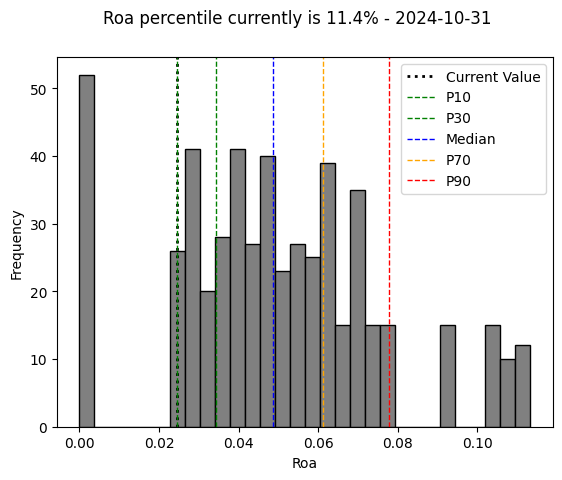

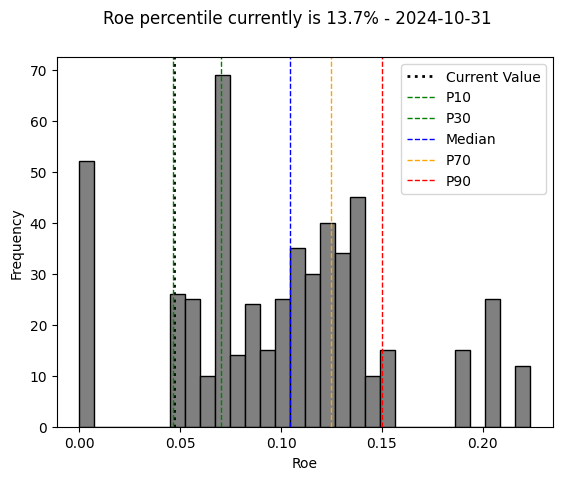

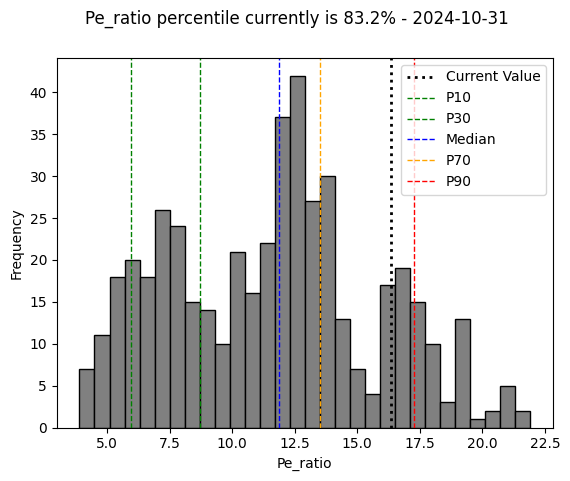

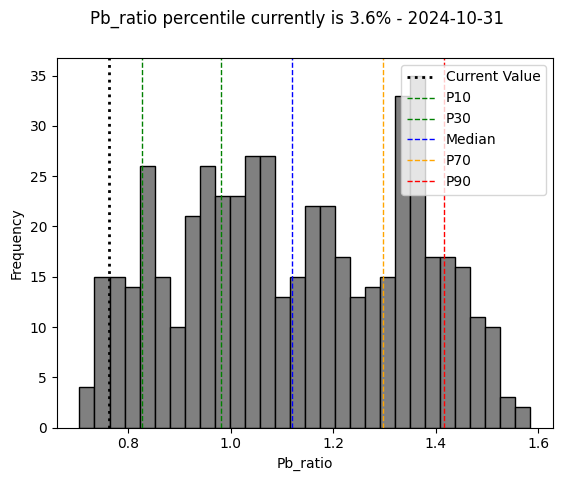

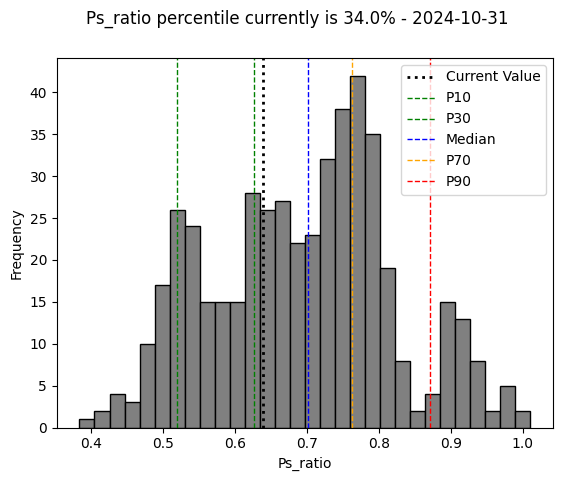

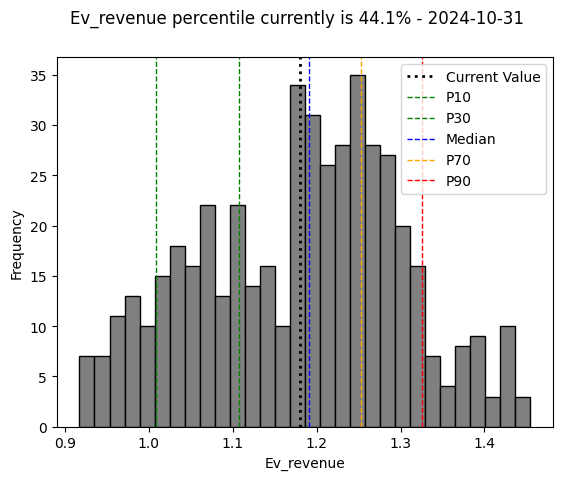

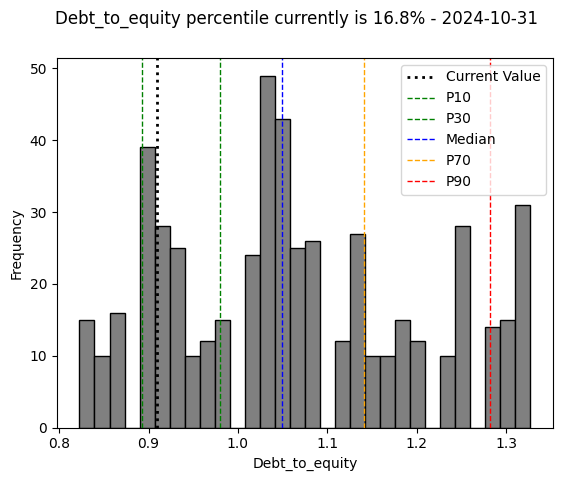

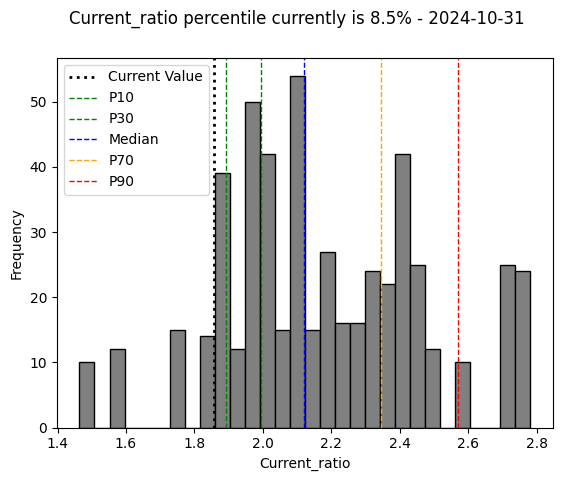

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.993523,-0.864088,0.195569,0.227293,-0.058056,-0.355140,0.182768
roe,0.993523,1.000000,-0.848368,0.270139,0.261158,-0.008728,-0.267505,0.177533
pe_ratio,-0.864088,-0.848368,1.000000,0.140959,0.292806,0.486017,0.165964,0.012257
pb_ratio,0.195569,0.270139,0.140959,1.000000,0.785793,0.748127,0.453682,0.252415
ps_ratio,0.227293,0.261158,0.292806,0.785793,1.000000,0.897431,0.006118,0.430647
ev_revenue,-0.058056,-0.008728,0.486017,0.748127,0.897431,1.000000,0.254137,0.204827
debt_to_equity,-0.355140,-0.267505,0.165964,0.453682,0.006118,0.254137,1.000000,-0.210471
current_ratio,0.182768,0.177533,0.012257,0.252415,0.430647,0.204827,-0.210471,1.000000


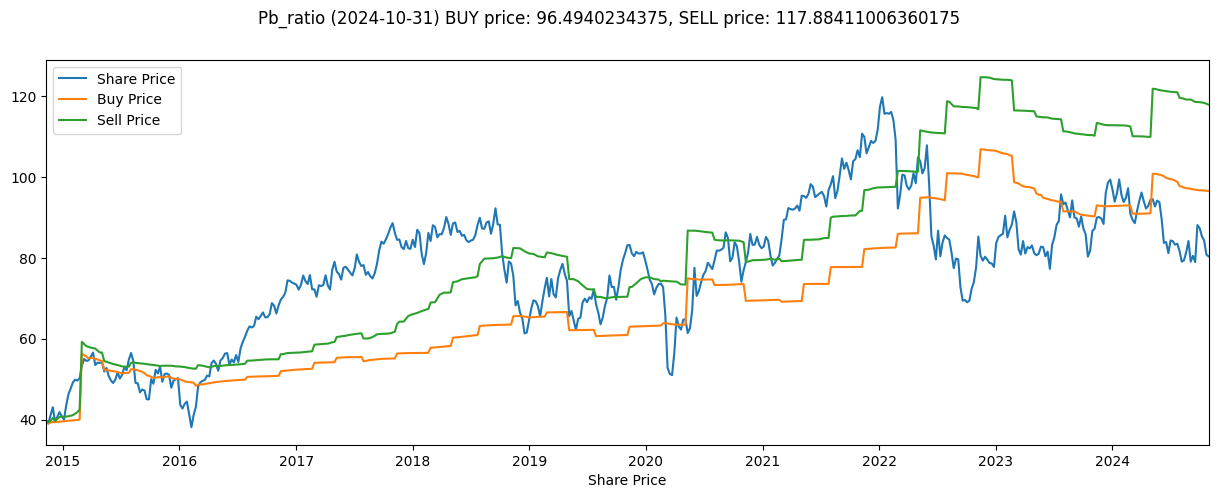

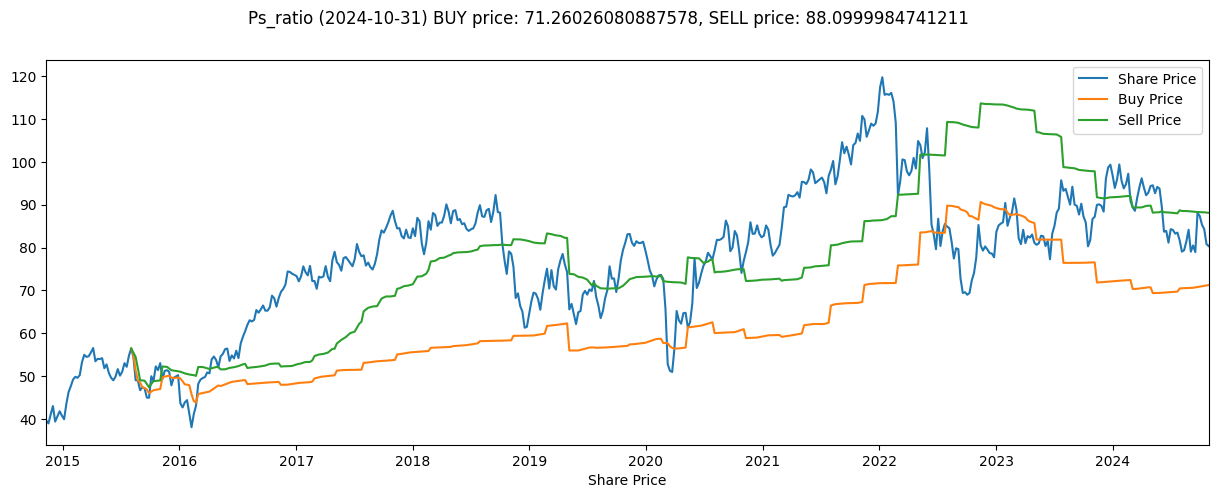

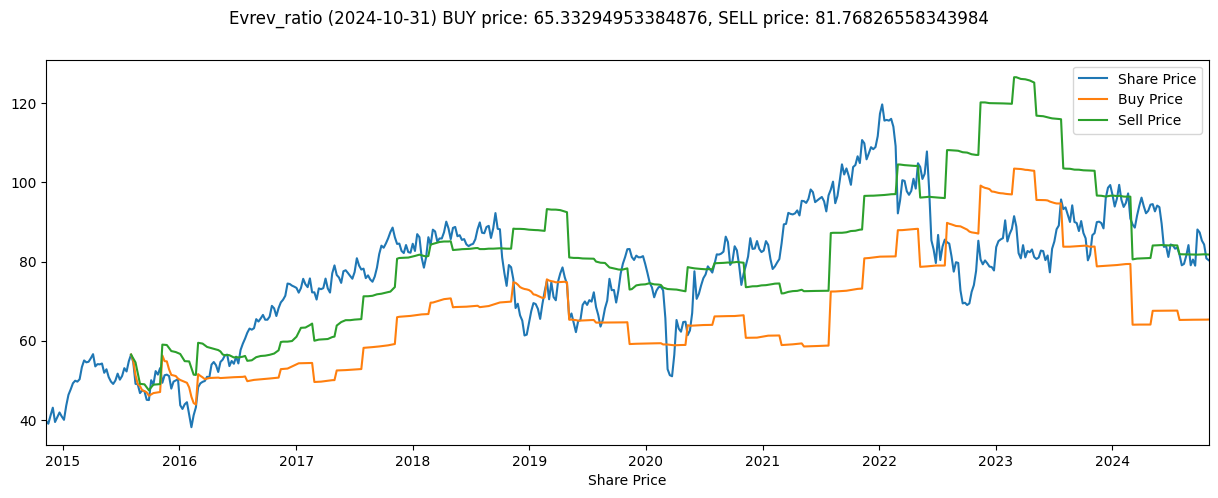

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)